This is a tutorial to use the flip package: https://github.com/corentinravoux/flip \
It is self-contained and can be used in google collab or on your environement \
All the data used are subsampled version of a simulation. \
The data size is small for the tutorial, do not use it for science case. \

In [1]:
%%capture
!pip install git+https://github.com/corentinravoux/flip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from flip import utils, plot_utils, data_vector, __flip_dir_path__
from flip.covariance import covariance, contraction, fitter

flip_base = Path(__flip_dir_path__)
data_path = flip_base / "data"
plt.style.use(data_path / "style.mplstyle")

[ 000000.00 ]: 09-23 01:45  root            INFO     No pypower module detected, gridding with this method is unavailable
ERROR:2025-09-23 01:45:28,859:jax._src.xla_bridge:502: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 500, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 150, in _check_cuda_versions
    assert cuda_versions is not None
           ^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError
[ 000000.21 ]: 09-23 01:45  jax._src.xla_bridge ERROR    

Loading the data, located in the package itself



In [3]:
data_velocity = pd.read_parquet(data_path / "data_velocity.parquet")


data_velocity_true = {**data_velocity.rename(columns={'vpec': 'velocity'}).to_dict(orient='list'), 
                      "velocity_error": np.zeros(len(data_velocity["vpec"].values))}


# Create the data Vector
DataTrueVel = data_vector.DirectVel(data_velocity_true)

ktt, ptt = np.loadtxt(data_path / "power_spectrum_tt.txt")
kmt, pmt = np.loadtxt(data_path / "power_spectrum_mt.txt")
kmm, pmm = np.loadtxt(data_path / "power_spectrum_mm.txt")

sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial) ** 2]]}


# Understanding the data

In [4]:
print("Number of simulated SNIa: ", len(data_velocity["ra"]))

Number of simulated SNIa:  2000


Plot the position and the velocity of the simulated SNIa, with true velocities, it is possible to see the large-scale velocity modes

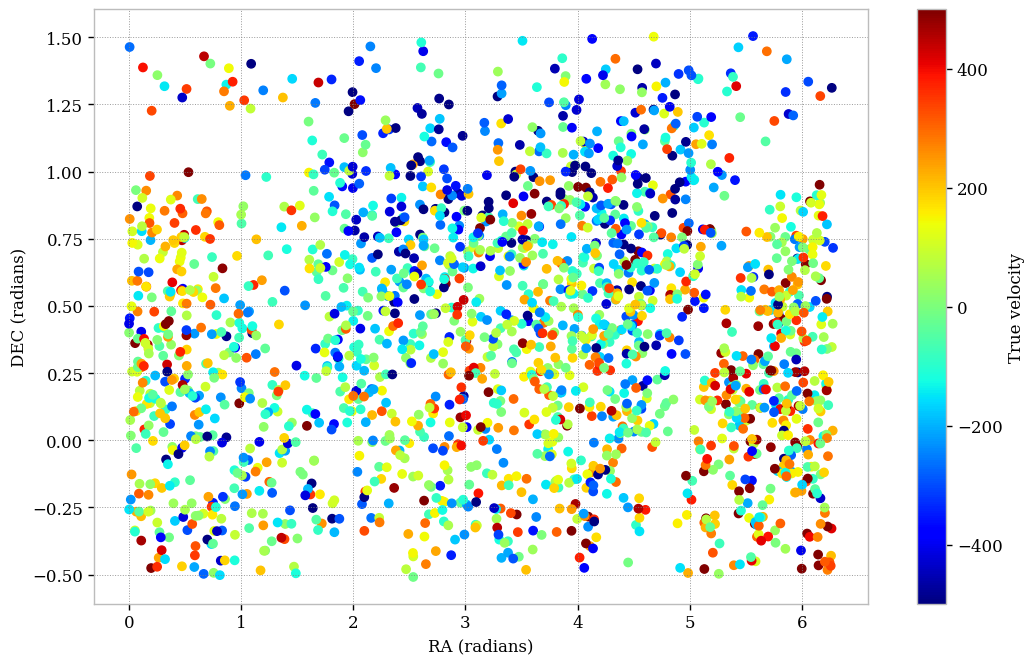

In [5]:
plt.scatter(data_velocity["ra"], data_velocity["dec"],c=data_velocity_true["velocity"],vmin=-500,vmax=500)
plt.xlabel("RA (radians)")
plt.ylabel("DEC (radians)")
cbar = plt.colorbar()
cbar.set_label("True velocity")

In [6]:
print("Available data properties", data_velocity.keys())

Available data properties Index(['zobs', 'mw_r_v', 'mw_ebv', 'sim_t0', 'sim_x1', 'sim_c', 'sim_x0', 'ra',
       'dec', 'zcos', 'zCMB', 'zpec', 'vpec', 'z2cmb', 'sim_mu', 'como_dist',
       'sim_mb', 'mag_sct', 't0', 'x0', 'x1', 'c', 'mb', 'e_t0', 'e_x0',
       'e_mb', 'e_x1', 'e_c', 'cov_x0_x1', 'cov_x0_c', 'cov_x1_c', 'cov_mb_x1',
       'cov_mb_c', 'chi2', 'ndof', 'status', 'rcom_zobs', 'hubble_norm'],
      dtype='object')


Computation of the Hubble diagram from the fitted properties, this is used during the fitting procedure

Text(0.5, 1.0, 'Hubble diagram')

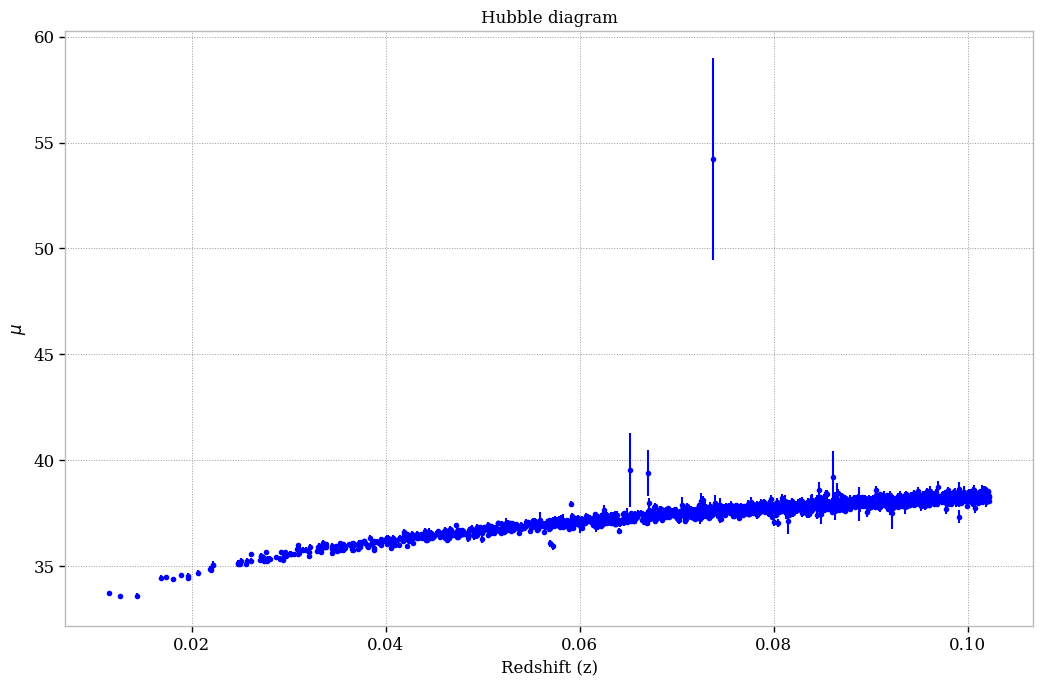

In [7]:
# Load the vector
DataVel = data_vector.snia_vectors.VelFromSALTfit(data_velocity.to_dict(orient='list'), velocity_estimator='full', h=0.70)

test_parameters = {"alpha":0.14,
                   "beta": 3.1,
                   "M_0": -19.01,
                   "sigma_M": 0.12}

mu = DataVel.compute_observed_distance_modulus(test_parameters)
variance_mu = DataVel.compute_observed_distance_modulus_variance(test_parameters)

mask = mu > 0
mask &= np.sqrt(variance_mu) - 0.1* mu < 0

plt.errorbar(DataVel.data["zobs"][mask], 
             mu[mask], 
             np.sqrt(variance_mu)[mask],
             linestyle="None",
             marker=".")

plt.xlabel("Redshift (z)")
plt.ylabel(r"$\mu$")
plt.title("Hubble diagram")

Compute the estimated velocities and errors from the Hubble diagram properties 

Text(0, 0.5, 'Velocity error')

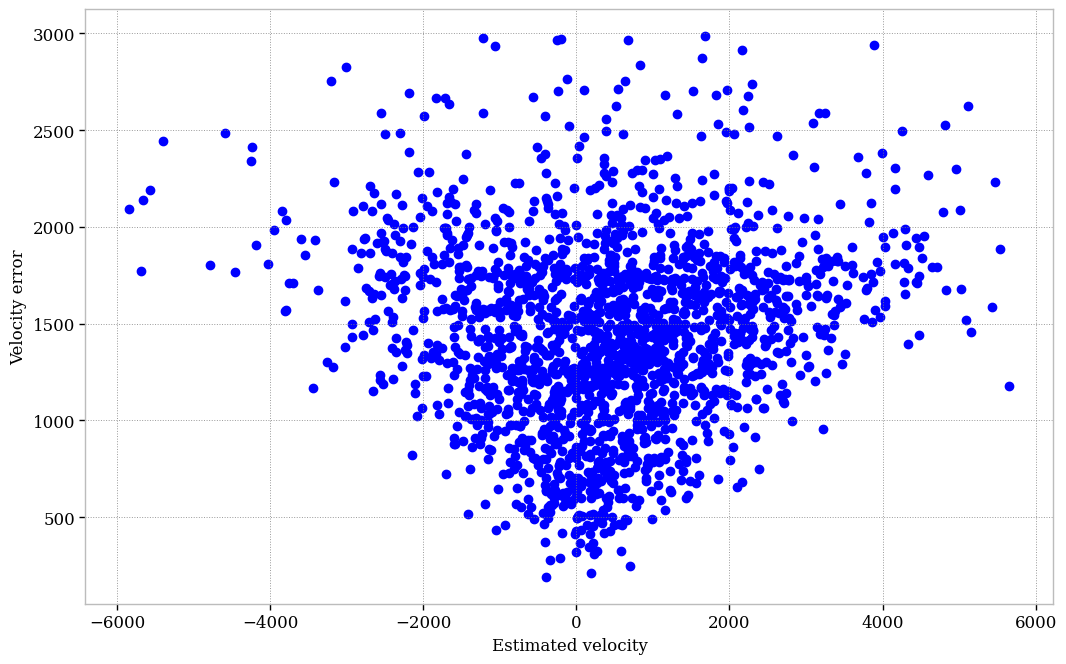

In [8]:
velocity, velocity_var = DataVel(test_parameters)

velocity_error = np.sqrt(velocity_var) 

mask = np.abs(velocity) < 6_000
mask &= velocity_error < 3_000

plt.scatter(velocity[mask], velocity_error[mask])
plt.xlabel("Estimated velocity")
plt.ylabel("Velocity error")

Plot the estimated properties, it is way harder to see the large-scale velocity modes since they are diluted inside the noise 

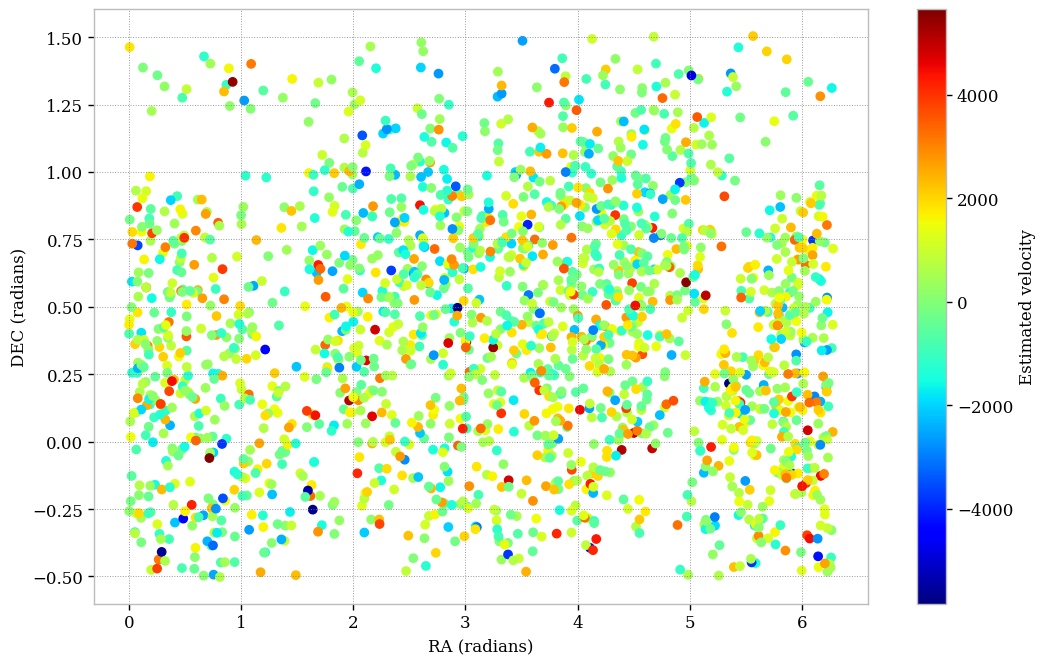

In [9]:
plt.scatter(DataVel.data["ra"][mask], DataVel.data["dec"][mask],c=velocity[mask])

plt.xlabel("RA (radians)")
plt.ylabel("DEC (radians)")
cbar = plt.colorbar()
cbar.set_label("Estimated velocity")


# Fit true velocity

First part of the flip package: fast computation of the covariance matrix based on theory and SNIa coordinates

In [10]:
size_batch=10_000
number_worker=16

# Compute covariance from DataVector
covariance_fit = DataTrueVel.compute_covariance("carreres23", power_spectrum_dict, size_batch=size_batch,number_worker=number_worker)

 /global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning:os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[ 000004.44 ]: 09-23 01:45  root            INFO     Covariance matrix generated from flip with carreres23 model in 1.73e+00 seconds


Second part of the flip package: compute the likelihood, and start the minuit fitter

In [11]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky"}


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                 }



minuit_fitter = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DataTrueVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)


print('Free parameters are:', minuit_fitter.likelihood.free_par)

minuit_fitter.run()


Free parameters are: ['sigv', 'fs8']


[ 000008.57 ]: 09-23 01:45  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.374e+04                  │              Nfcn = 31               │
│ EDM = 7.25e-06 (Goal: 0.0001)    │            time = 3.9 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────

{'fs8': 0.3693224285689417, 'sigv': 197.6136246901063}

# Fit true velocity interpolation sigma_u

In the model, there is a sigma_u parameter which can be interpreted to the smoothing of SNIa position due to peculiar velocities. \
To fit simultaneously this parameter, we interpolate the covariance matrix. 

In [12]:
sigmau_list = np.linspace(10.0, 20.0,10)
covariance_list = []
size_batch=10_000
number_worker=16


for sigu in sigmau_list:
    
    power_spectrum_dict = {"vv": [[ktt, ptt* utils.Du(ktt, sigu)**2]]}

    covariance_list.append(
        DataTrueVel.compute_covariance(
            "carreres23",
            power_spectrum_dict,
            size_batch=size_batch,
            number_worker=number_worker
        )
    )


[ 000011.04 ]: 09-23 01:45  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.47e+00 seconds
[ 000013.52 ]: 09-23 01:45  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.34e+00 seconds
[ 000016.11 ]: 09-23 01:45  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.43e+00 seconds
[ 000018.56 ]: 09-23 01:45  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.28e+00 seconds
[ 000020.85 ]: 09-23 01:45  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.17e+00 seconds
[ 000023.16 ]: 09-23 01:45  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.20e+00 seconds
[ 000025.51 ]: 09-23 01:45  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.18e+00 seconds
[ 000028.24 ]: 09-23 01:45  root            INFO     Covariance matri

In [13]:
likelihood_type="multivariate_gaussian_interp1d"
likelihood_properties = {"inversion_method": "cholesky", "use_jit": True}

parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "fixed" : False,
                         },
                  "sigu": {"value": 15.0,
                          "limit_low" : 13.0,
                          "limit_up" : 17.0,
                          "fixed" : False,
                         },
                 }


minuit_fitter_interp = fitter.FitMinuit.init_from_covariance(
        covariance_list,
        DataTrueVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        interpolation_value_name = "sigu",
        interpolation_value_range = sigmau_list,
)

print('Free parameters:', minuit_fitter_interp.likelihood.free_par)

minuit_fitter_interp.run()


Free parameters: ['sigu', 'sigv', 'fs8']


[ 000052.70 ]: 09-23 01:46  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.374e+04                  │              Nfcn = 73               │
│ EDM = 3.49e-05 (Goal: 0.0001)    │           time = 19.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────

{'fs8': 0.3584746211137037,
 'sigv': 196.17047509263173,
 'sigu': 13.431159023458074}

# Fit estimate velocity

Let's first apply some simple masks to remove abherant estimated velocities 

In [14]:
test_parameters = {"alpha":0.14,
                   "beta": 3.1,
                   "M_0": -19.133,
                   "sigma_M": 0.12}

velocity, velocity_var = DataVel(test_parameters)
velocity_error = np.sqrt(velocity_var)
mask = np.abs(velocity) < 3_000
mask &= velocity_error < 3_000

data_velocity_cleaned, _ = DataVel.get_masked_data_and_cov(mask)
DataVelCleaned = data_vector.snia_vectors.VelFromSALTfit(data_velocity_cleaned, velocity_estimator='full', h=0.70)

In [15]:
size_batch=10_000
number_worker=16

covariance_fit = DataVelCleaned.compute_covariance(
    "carreres23",  
    power_spectrum_dict,
    size_batch=size_batch,
    number_worker=number_worker,
)

[ 000055.88 ]: 09-23 01:46  root            INFO     Covariance matrix generated from flip with carreres23 model in 2.81e+00 seconds


In [16]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {"inversion_method": "cholesky"}


parameter_dict = {"fs8": {"value": 0.4,
                          "limit_low" : 0.0,
                          "limit_up" : 1.0,
                          "fixed" : False,
                         },
                  "sigv": {"value": 200,
                          "limit_low" : 0.0,
                          "limit_up" : 1000,
                          "fixed" : False,
                         },
                  "alpha": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 0.25,
                          "fixed" : False,
                         },
                  "beta": {"value": 3.0,
                          "limit_low" : 2.5,
                          "limit_up" : 4.5,
                          "fixed" : False,
                         },
                  "M_0": {"value": -19,
                          "limit_low" : -21,
                          "limit_up" : -18,
                          "fixed" : False,
                         },
                  "sigma_M": {"value": 0.1,
                          "limit_low" : 0.0,
                          "limit_up" : 100.0,
                          "fixed" : False,
                         }}

minuit_fitter_velest = fitter.FitMinuit.init_from_covariance(
        covariance_fit,
        DataVelCleaned,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties
)

print('Free parameters:', minuit_fitter_velest.likelihood.free_par)

minuit_fitter_velest.run()


 /global/homes/r/ravouxco/.local/perlmutter/python-3.11/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning:Assigned errors must be positive. Non-positive values are replaced by a heuristic.


Free parameters: ['alpha', 'beta', 'M_0', 'sigma_M', 'sigv', 'fs8']


[ 000073.07 ]: 09-23 01:46  root            INFO     ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.465e+04                  │              Nfcn = 204              │
│ EDM = 5.05e-05 (Goal: 0.0001)    │           time = 17.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬────────

{'fs8': 0.5424038990952811,
 'sigv': 476.2979741653817,
 'alpha': 0.12829656768951989,
 'beta': 3.0215138844189955,
 'M_0': -19.090120634877966,
 'sigma_M': 0.09023147533055897}

# Some plots

Plot of the latest covariance matrix computed 

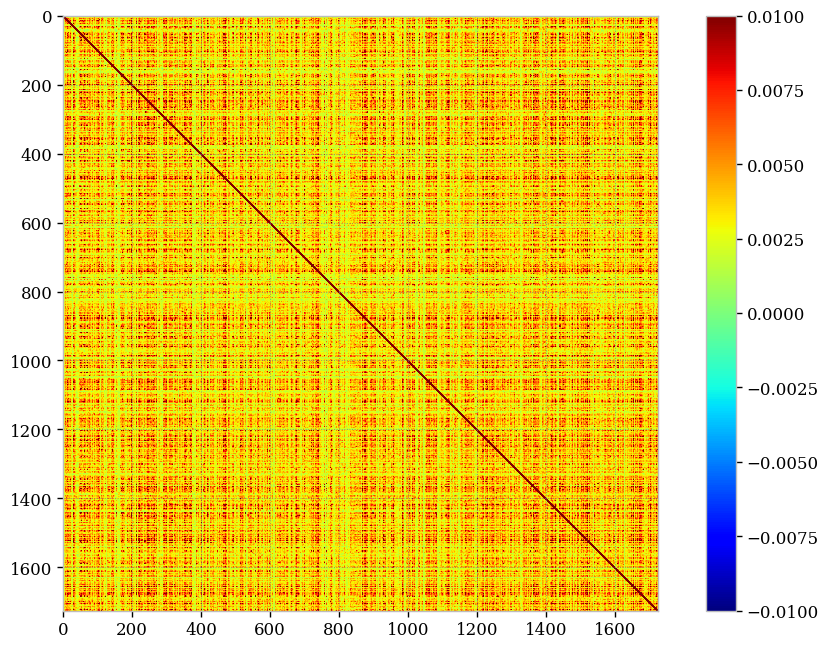

In [17]:
plot_utils.plot_correlation_from_likelihood(
    minuit_fitter_velest.likelihood,
    parameter_dict,
    vmin=-0.01, vmax=0.01
)

The covariance matrix model can be contracted when we consider parallel and perpendicular separations. \
It allows to see the model more clearly:

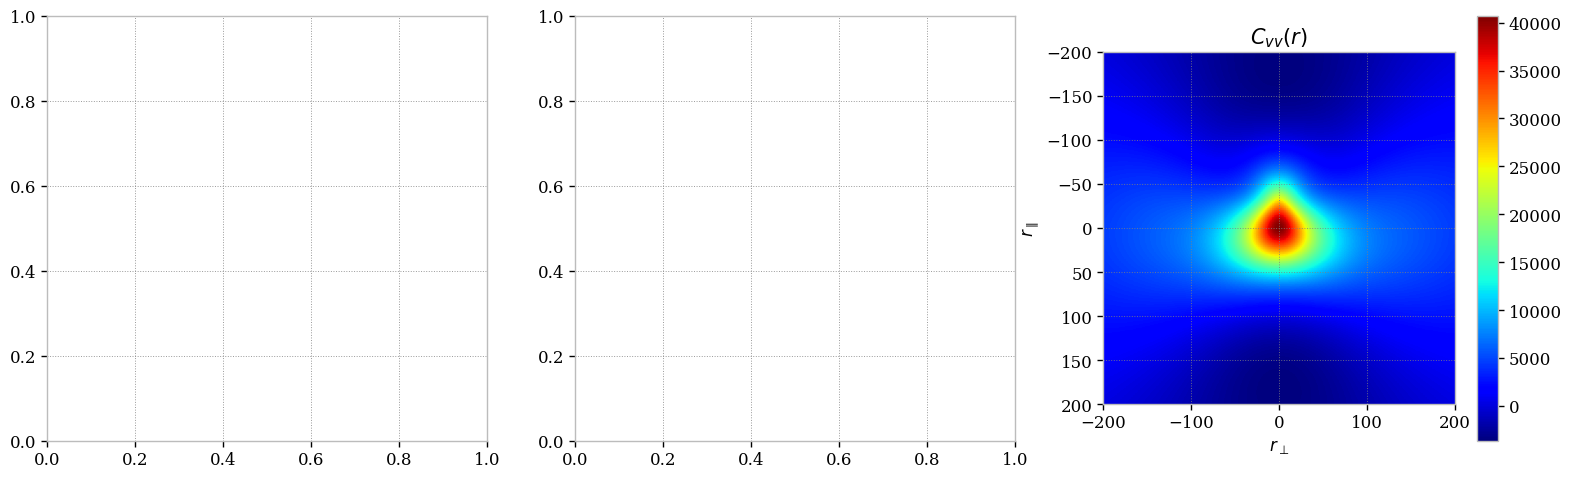

In [18]:

r_perpendicular = np.linspace(-200,200,200)
r_parallel = np.linspace(-200,200,200)

r_reference_parallel = 30 
r_reference_perpendicular = 0 

contraction_plot = contraction.Contraction.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    r_perpendicular,
    r_parallel,
    r_reference_perpendicular,
    r_reference_parallel,
    coordinate_type="rprt",
)

parameter_values_dict = {parameters: parameter_dict[parameters]["value"] for parameters in parameter_dict}

plot_utils.plot_2d_contraction(contraction_plot, 
                    parameter_values_dict, 
                    rs_multiplied = True)


# MCMC true vel fit

In [19]:
sn_data = pd.read_parquet(data_path / "data_velocity.parquet")

# Removing bad fits
sn_data = sn_data[np.array(sn_data["status"]) != False]
sn_data = sn_data[np.array(sn_data["status"]) != None]

coordinates_velocity = np.array([sn_data["ra"], sn_data["dec"], sn_data["como_dist"]])

data_velocity = sn_data.to_dict("list")
for key in data_velocity.keys():
    data_velocity[key] = np.array(data_velocity[key])
data_velocity["velocity"] = data_velocity.pop("vpec")
data_velocity["velocity_error"] = np.zeros_like(data_velocity["velocity"])


ktt, ptt = np.loadtxt(data_path / "power_spectrum_tt.txt")
kmt, pmt = np.loadtxt(data_path / "power_spectrum_mt.txt")
kmm, pmm = np.loadtxt(data_path / "power_spectrum_mm.txt")

sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[ktt, ptt * utils.Du(ktt, sigmau_fiducial) ** 2]]}


In [20]:

likelihood_type="multivariate_gaussian"
likelihood_properties = {
        "inversion_method": "cholesky", "use_jit": True
        }


parameter_dict = {
        "fs8": {
                "randfun": lambda size: np.random.normal(0.4, 0.001, size=size),
                },
        "sigv": {
                "randfun": lambda size: np.random.normal(200, 10, size=size),
                },
        }


In [21]:
size_batch=10_000
number_worker=16

covariance_fit = DataTrueVel.compute_covariance(
    "carreres23",
    power_spectrum_dict,
    size_batch=size_batch,
    number_worker=number_worker
)

mcmc_fitter = fitter.FitMCMC.init_from_covariance(
        covariance_fit,
        DataTrueVel,
        parameter_dict,
        likelihood_type=likelihood_type,
        likelihood_properties = likelihood_properties,
        nwalkers=4
)


 /global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning:os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
[ 000079.10 ]: 09-23 01:46  root            INFO     Covariance matrix generated from flip with carreres23 model in 3.05e+00 seconds


In [22]:
%%time
sampler = mcmc_fitter.sampler.run_chains(100)

CPU times: user 1min 10s, sys: 34.6 s, total: 1min 45s
Wall time: 34 s
